<a href="https://colab.research.google.com/github/slustgarten/profile/blob/master/Saul_Cohort_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a test to see if I can run cohort analysis using Python. I'm following [this tutorial](https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea).

We'll start by importing the relevant libraries:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

Let's import the CSV from google drive (need to figure out how to connect to SQL later on).

In [2]:
from google.colab import files
uploaded = files.upload()

Saving cohort_test.csv to cohort_test.csv


In [3]:
df = pd.read_csv('cohort_test.csv',
                   dtype={'user_id': str},
                   parse_dates=['active_ds'], 
                   infer_datetime_format=True)

df.head()

,user_id,deployment_id,instance_name,created_ds,station_id,recordtype,email,account_name,user_role,active_ds,first_login,date_diff,date_diff_adj
0,223Kpg8k7xiD3qPhx,43966.0,weda,2020-10-12 06:41:24,NaN,Admin Login,c.mihlan@weda.de,NaN,Customer Admin,2020-10-15,2020-10-15 00:00:00,0.0,NaN
1,238HPz83SvauzCoY2,52258.0,loadtest-12,2021-03-26 18:54:24,TR7jbo4xHBhwLKrpk,App Open,Operator,NaN,Operator,2021-04-20,2021-04-20 00:00:00,0.0,NaN
2,238HPz83SvauzCoY2,NaN,loadtest-12,NaN,NaN,Table Record Updated,Operator,NaN,Operator,2021-04-20,2021-04-20 00:00:00,0.0,NaN
3,238HPz83SvauzCoY2,NaN,loadtest-12,NaN,NaN,Table Record Updated,Operator,NaN,Operator,2021-04-20,2021-04-20 00:00:00,0.0,NaN
4,238HPz83SvauzCoY2,NaN,loadtest-12,NaN,NaN,Table Record Updated,Operator,NaN,Operator,2021-04-20,2021-04-20 00:00:00,0.0,NaN


Inspect numerical values (not super meaningful in this case because they are just date values)

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
deployment_id,1110712.0,13880.978841,14809.507287,1048.0,2278.0,8823.0,15809.0,53398.0
date_diff,1376081.0,4.980763,5.363017,0.0,1.0,3.0,8.0,22.0
date_diff_adj,1275200.0,5.374791,5.377685,0.0,1.0,3.0,8.0,22.0


Then, we calculate an aggregate metric indicating how many logins were placed by each customer. NEED TO DOUBLE CHECK because original code was using unique invoice number which we don't have for logins...


In [9]:
n_logins = df.groupby(['user_id'])['active_ds'].nunique()
mult_logins_perc = np.sum(n_logins > 1) / df['user_id'].nunique()
print(f'{100 * mult_logins_perc:.2f}% of customers logged in more than once.')

55.73% of customers logged in more than once.


Let's plot this on histogram

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


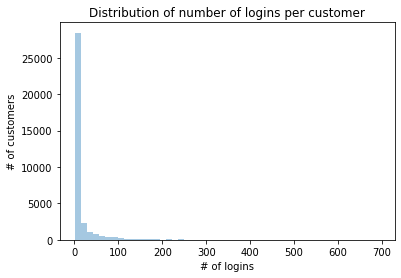

In [10]:
ax = sns.distplot(n_logins, kde=False, hist=True)
ax.set(title='Distribution of number of logins per customer',
       xlabel='# of logins', 
       ylabel='# of customers');

#Cohort Analysis
We create the cohort and login_month variables. The first one indicates the monthly cohort based on the first purchase date (calculated per customer).

In [11]:
df['login_month'] = df['active_ds'].dt.to_period('M')
df['cohort'] = df.groupby('user_id')['active_ds'] \
                 .transform('min') \
                 .dt.to_period('M') 

Then, we aggregate the data per cohort and order_month and count the number of unique customers in each group. Additionally, we add the period_number, which indicates the number of periods between the cohort month and the month of the purchase.

In [13]:
df_cohort = df.groupby(['cohort', 'login_month']) \
              .agg(n_customers=('user_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.login_month - df_cohort.cohort).apply(attrgetter('n'))

The next step is to pivot the df_cohort table in a way that each row contains information about a given cohort and each column contains values for a certain period.

In [14]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

To obtain the retention matrix, we need to divide the values each row by the row's first value, which is actually the cohort size — all customers who made their first purchase in the given month.

In [15]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

Lastly, we plot the retention matrix as a heatmap. Additionally, we wanted to include extra information regarding the cohort size. That is why we in fact created two heatmaps, where the one indicating the cohort size is using a white only colormap — no coloring at all.

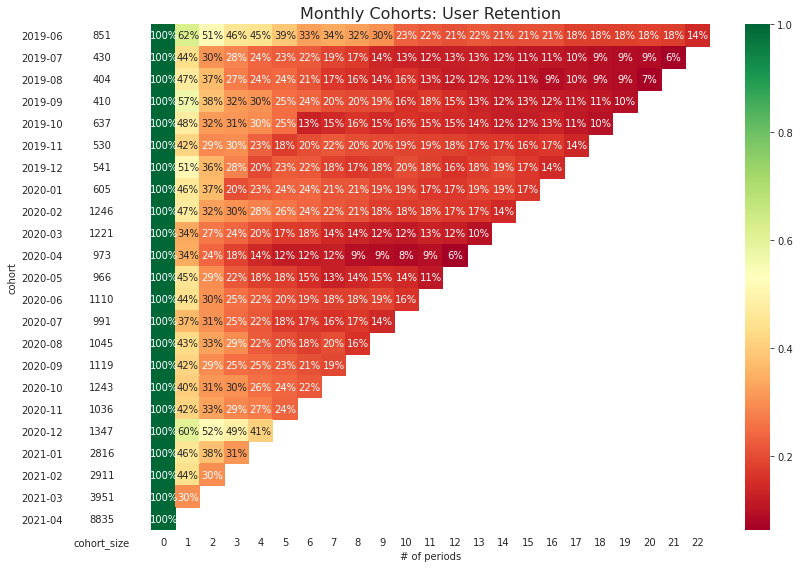

In [16]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()